In [1]:
import pandas as pd
from src.train import train_loop, test_loop
from src.model import CNNLSTMModel
from src.dataset import *
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [2]:
performe_visualization = False

In [3]:
# some important parameters
pre_day = 5
window_size = 12*24*7 # 5 minutes * 12 * 24 = 1 day
stride = 12 # 1 hour stride

feature_cols = [
    #"metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    #"metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED",                  # DC voltage
    "metric.AC_POWER.MEASURED",                     # AC power
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')], # anomalies in the data
]

## Data Preprocessing
### Load Data

In [4]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions_w_maintenance.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [5]:
visualize_failure_timeline(failure_sessions)

In [6]:
if performe_visualization:
    # Visualize the raw data
    visualize_hourly_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

In [7]:
failure_sessions = failure_sessions[failure_sessions['maintenance'] == False]

### Data Cleaning

In [8]:
print("inverter_data shape:", inverter_data.shape)
filtered_data = exclude_periods_from_data(inverter_data, exclude_periods)
print("Excluded data shape:", filtered_data.shape)

inverter_data shape: (6126272, 59)
Excluded 2 periods, remaining data size: 5172608
Excluded data shape: (5172608, 59)


In [9]:
print("failure_sessions shape:", failure_sessions.shape)
failure_sessions['event_local_time'] = failure_sessions['start_time']
filtered_sessions = exclude_periods_from_data(failure_sessions, exclude_periods)
filtered_sessions['event_local_time'] = filtered_sessions['end_time']
filtered_sessions = exclude_periods_from_data(filtered_sessions, exclude_periods)
print("failure_sessions shape:", filtered_sessions .shape)

failure_sessions shape: (32, 6)
Excluded 2 periods, remaining data size: 27
Excluded 2 periods, remaining data size: 27
failure_sessions shape: (27, 7)


In [10]:
visualize_failure_timeline(filtered_sessions)

In [11]:
# remove unused columns
filtered_data = filtered_data[['event_local_time', 'device_name'] + feature_cols]

In [12]:
if performe_visualization:
    # Visualize the filtered data
    visualize_hourly_mean_values(filtered_data, failure_sessions, feature_cols, 'visualization', 'filtered_data')

In [13]:
downsampled_data = downsample_inverter_raw(filtered_data, drop_empty_bins=False)

Downsampling 5172608 rows using following method: 
                          Column Aggregation
0  metric.AC_VOLTAGE_AB.MEASURED        mean
1  metric.AC_VOLTAGE_BC.MEASURED        mean
2  metric.AC_VOLTAGE_CA.MEASURED        mean
3     metric.DC_VOLTAGE.MEASURED        mean
4       metric.AC_POWER.MEASURED        mean


In [14]:
downsampled_data.describe()

,metric.AC_VOLTAGE_AB.MEASURED,metric.AC_VOLTAGE_BC.MEASURED,metric.AC_VOLTAGE_CA.MEASURED,metric.DC_VOLTAGE.MEASURED,metric.AC_POWER.MEASURED
count,646576.000000,646576.000000,646576.000000,646576.000000,646576.000000
mean,34440.574219,34440.582031,34440.570312,1208.850342,917.283813
std,241.003937,240.983612,241.117264,794.940552,341.721008
min,28501.857422,28501.974609,28501.974609,2.285878,-0.142857
25%,34313.707031,34313.664062,34313.687500,601.812683,679.852600
50%,34433.976562,34433.992188,34434.003906,844.467285,896.466858
75%,34570.402344,34570.421875,34570.410156,1659.175659,1137.243652
max,35397.945312,35398.085938,35398.085938,5493.280762,2470.843018


In [15]:
len(downsampled_data)

1004528

### Anomoly Detection

In [16]:
if "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED" in filtered_data.columns:
    anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
    filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
    print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

### Data Labeling

In [17]:
labeled_df = prepare_dataset(downsampled_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 7348
Total rows: 990416


### Missing Value Imputation

In [18]:
imputed_df = missing_value_imputation(labeled_df, feature_cols, time_col='event_local_time', device_col='device_name', short_gap_limit=0, long_fill_value=0.0, add_missing_mask=True)

In [19]:
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

In [20]:
imputed_df

,event_local_time,device_name,metric.AC_VOLTAGE_AB.MEASURED,metric.AC_VOLTAGE_BC.MEASURED,metric.AC_VOLTAGE_CA.MEASURED,metric.DC_VOLTAGE.MEASURED,metric.AC_POWER.MEASURED,label,metric.AC_VOLTAGE_AB.MEASURED_missing,metric.AC_VOLTAGE_BC.MEASURED_missing,metric.AC_VOLTAGE_CA.MEASURED_missing,metric.DC_VOLTAGE.MEASURED_missing,metric.AC_POWER.MEASURED_missing
0,2021-12-24 00:00:00,INV 51,34614.589844,34614.339844,34614.554688,2367.390625,916.856506,0,0.0,0.0,0.0,0.0,0.0
1,2021-12-24 00:30:00,INV 51,34627.761719,34627.765625,34628.042969,1691.753784,670.268372,0,0.0,0.0,0.0,0.0,0.0
2,2021-12-24 01:00:00,INV 51,34591.800781,34591.671875,34603.433594,2361.303711,948.311401,0,0.0,0.0,0.0,0.0,0.0
3,2021-12-24 01:30:00,INV 51,0.000000,0.000000,0.000000,0.000000,0.000000,0,1.0,1.0,1.0,1.0,1.0
4,2021-12-24 02:00:00,INV 51,34668.531250,34668.472656,34668.585938,1689.845093,700.789734,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990411,2025-07-23 21:30:00,INV 66,34507.347656,34507.347656,34507.210938,669.122498,568.676575,0,0.0,0.0,0.0,0.0,0.0
990412,2025-07-23 22:00:00,INV 66,34416.417969,34418.320312,34418.320312,838.680115,1018.181702,0,0.0,0.0,0.0,0.0,0.0
990413,2025-07-23 22:30:00,INV 66,34526.558594,34526.480469,34526.535156,600.931030,699.501648,0,0.0,0.0,0.0,0.0,0.0
990414,2025-07-23 23:00:00,INV 66,0.000000,0.000000,0.000000,0.000000,0.000000,0,1.0,1.0,1.0,1.0,1.0


### Feature Engineering

In [21]:
imputed_df['hour_of_day'] = imputed_df['event_local_time'].dt.hour
imputed_df['month_of_year'] = imputed_df['event_local_time'].dt.month
extended_feature_cols += ['hour_of_day', 'month_of_year']


In [22]:
if performe_visualization:
    visualize_hourly_mean_values(imputed_df, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data')

### Split Dataset

In [22]:
train_df = imputed_df[imputed_df['event_local_time'] <= pd.Timestamp('2023-12-15')].copy()
val_df = imputed_df[(imputed_df['event_local_time'] > pd.Timestamp('2023-12-15')) & (imputed_df['event_local_time'] <= pd.Timestamp('2024-07-31'))].copy()
test_df = imputed_df[imputed_df['event_local_time'] > pd.Timestamp('2024-07-31')].copy()

In [24]:
#train_df, test_df = train_test_split_on_time(imputed_df, 0.3)
#val_df, test_df = train_test_split_on_time(test_df, 0.3)

In [23]:
extended_feature_cols

['metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_of_day',
 'month_of_year']

### Standardization

In [24]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols + ['hour_of_day', 'month_of_year']
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [27]:
if performe_visualization:
    visualize_hourly_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data')
    visualize_hourly_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data')
    visualize_hourly_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data')

Visualizing devices: 100%|██████████| 16/16 [01:09<00:00,  4.36s/it]


Visualization saved at visualization/train_data/*.html


Visualizing devices: 100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


Visualization saved at visualization/val_data/*.html


Visualizing devices:  31%|███▏      | 5/16 [00:12<00:28,  2.60s/it]


KeyboardInterrupt: 

In [25]:
train_df['label'].value_counts()

0    538963
1      3988
Name: label, dtype: int64

### Create Dataset/Data Loader

In [26]:
stride = 1
window_size = 2*24*7 # 30 minutes * 24 * 7 = 1 week

In [27]:
positive_train_ds = PositiveInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=1)
negative_train_ds = NegativeInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=1)

Processing devices: 100%|██████████| 16/16 [00:03<00:00,  4.29it/s]


In [28]:
from torch.utils.data import DataLoader


train_ds = combine_dataset([positive_train_ds, negative_train_ds])
del positive_train_ds, negative_train_ds

val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=stride)

Processing devices: 100%|██████████| 16/16 [00:02<00:00,  7.23it/s]


In [29]:
train_ds.X.shape

torch.Size([532083, 336, 12])

In [30]:
pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

(0.0    528473
 1.0      3610
 dtype: int64,
 0.0    165672
 1.0      1440
 dtype: int64,
 0.0    263023
 1.0      1920
 dtype: int64)

In [31]:
pd.value_counts(train_ds.y.numpy())

0.0    528473
1.0      3610
dtype: int64

In [38]:
train_ds.y.numpy()

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler, RandomSampler
import torch

num_samples = len(train_ds)*0.1  # 10% of the training dataset size

# 假設 y 是樣本的 label 張量
class_sample_count = pd.value_counts(train_ds.y.numpy())
weights = 1. / class_sample_count
sample_weights = weights[train_ds.y.numpy()].to_numpy() # 每個樣本對應的抽樣權重
print(sample_weights)

balanced_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=num_samples,
    replacement=True
)
print(weights, num_samples)

[2.77008310e-04 2.77008310e-04 2.77008310e-04 ... 1.89224426e-06
 1.89224426e-06 1.89224426e-06]
0.0    0.000002
1.0    0.000277
dtype: float64 10000


In [ ]:
random_sampler = RandomSampler(val_ds, num_samples=len(val_ds)*0.1, replacement=True)

In [44]:
batch_size = 2**9

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=balanced_sampler,  num_workers=6, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, sampler=random_sampler, num_workers=6, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

## Train Model

In [53]:
model = CNNLSTMModel(num_features=len(extended_feature_cols), cnn_out_channels=64, lstm_hidden_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 建議先用較溫和的 pos_weight（例：5），再用驗證集掃描最佳值
pos_weight_value = 2.0
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], dtype=torch.float)).to('cuda')


In [ ]:
#model.load_state_dict(torch.load(r'model\0812_0003\epoch_15.pth', weights_only=True))

In [64]:
log = train_loop(
    model, train_loader, val_loader, 
    log_interval=5, 
    num_epochs=10, 
    optimizer=optimizer, 
    criterion=criterion,
    save_interval=1,
    save_path=r'model\0812_2309'
)

Model moved to cuda
Resuming training from epoch 21
[Epoch 21/10] Step 0/20 - Loss: 0.4754
[Epoch 21/10] Step 5/20 - Loss: 0.5327
[Epoch 21/10] Step 10/20 - Loss: 0.5883
[Epoch 21/10] Step 15/20 - Loss: 0.4482
🔁 Epoch 21 finished. Avg Train Loss: 0.5373
✅ Validation Loss: 0.4457 | Accuracy: 80.50% | AUC-PR: 0.0083
[Epoch 22/10] Step 0/20 - Loss: 0.5159
[Epoch 22/10] Step 5/20 - Loss: 0.4769
[Epoch 22/10] Step 10/20 - Loss: 0.5266
[Epoch 22/10] Step 15/20 - Loss: 0.5536
🔁 Epoch 22 finished. Avg Train Loss: 0.5374
✅ Validation Loss: 0.3631 | Accuracy: 85.80% | AUC-PR: 0.0092
[Epoch 23/10] Step 0/20 - Loss: 0.5169
[Epoch 23/10] Step 5/20 - Loss: 0.4889
[Epoch 23/10] Step 10/20 - Loss: 0.5028
[Epoch 23/10] Step 15/20 - Loss: 0.4512
🔁 Epoch 23 finished. Avg Train Loss: 0.5065
✅ Validation Loss: 0.2787 | Accuracy: 91.80% | AUC-PR: 0.0085
Best model saved at epoch 23 with loss 0.2787
[Epoch 24/10] Step 0/20 - Loss: 0.5575
[Epoch 24/10] Step 5/20 - Loss: 0.5316
[Epoch 24/10] Step 10/20 - Loss:

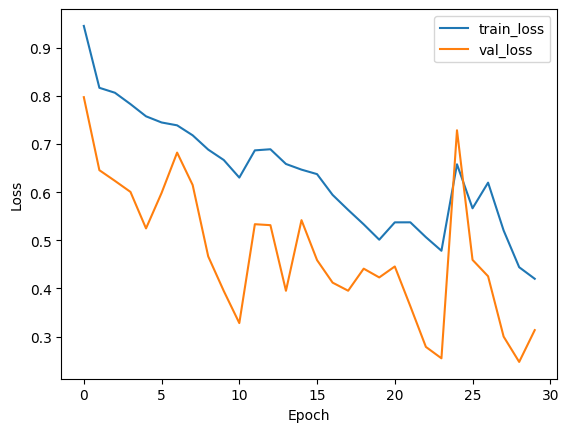

In [65]:
import matplotlib.pyplot as plt
#log = pd.read_csv('model/0811_2042/training_log.csv')
plt.plot(log['train_loss'], label='train_loss')
plt.plot(log['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Model Evaluation

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_model(model, data_loader, best_threshold=0.5, device='cuda', criterion=None):
    trues, predictions, outputs = test_loop(model, data_loader, device=device, criterion=criterion, best_threshold=best_threshold)
    print(classification_report(trues, predictions , target_names=['Normal', 'Failure']))
    print(confusion_matrix(trues, predictions ))
    roc_auc = roc_auc_score(trues, outputs)
    print(f"ROC AUC: {roc_auc:.4f}")
    curve = roc_curve(trues, outputs)

    plt.figure(figsize=(8, 6))
    plt.plot(curve[0], curve[1], label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

In [ ]:
model.load_state_dict(torch.load(r'model\0812_2019\best_model.pth', weights_only=True))

Performance on Training Set:
🔍 Test Loss: 0.4087 | Accuracy: 83.14%
              precision    recall  f1-score   support

      Normal       0.99      0.67      0.80      5001
     Failure       0.75      0.99      0.85      4999

    accuracy                           0.83     10000
   macro avg       0.87      0.83      0.83     10000
weighted avg       0.87      0.83      0.83     10000

[[3346 1655]
 [  31 4968]]
ROC AUC: 0.9377


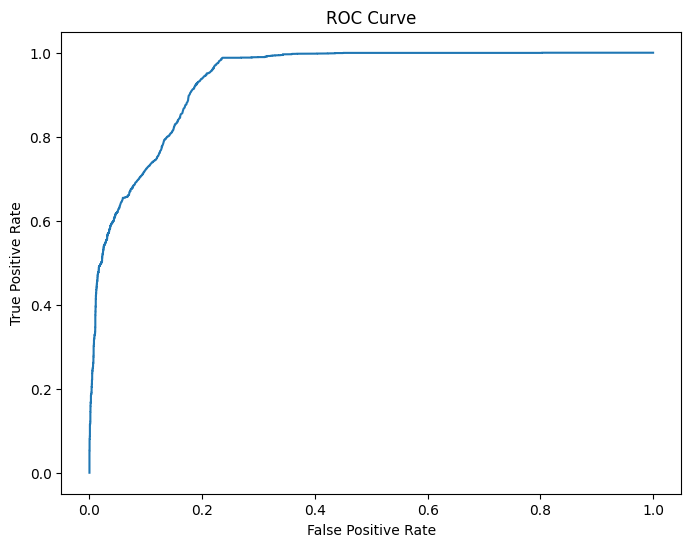

In [67]:
print("Performance on Training Set:")
evaluate_model(model, train_loader, best_threshold=0.5, device='cuda', criterion=criterion)

In [68]:
val_loader_for_eval = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

In [69]:
trues, predictions, outputs = test_loop(model, val_loader_for_eval, device='cuda', criterion=criterion)

🔍 Test Loss: 0.2928 | Accuracy: 89.74%


In [70]:
from sklearn.metrics import precision_recall_curve, f1_score

# y_val: 驗證集真實標籤 (0/1)
# y_val_scores: 模型輸出的機率（sigmoid 後）或 logits
precisions, recalls, thresholds = precision_recall_curve(trues, outputs)

# 計算 F1
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Precision:", precisions[best_idx])
print("Recall:", recalls[best_idx])
print("F1:", f1_scores[best_idx])


Best threshold: 0.1647001
Precision: 0.012029996875325487
Recall: 0.16041666666666668
F1: 0.022381550877294314


Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       0.99      0.89      0.94    165672
     Failure       0.01      0.16      0.02      1440

    accuracy                           0.88    167112
   macro avg       0.50      0.52      0.48    167112
weighted avg       0.98      0.88      0.93    167112

[[146701  18971]
 [  1209    231]]
ROC AUC: 0.4544


Text(0.5, 1.0, 'ROC Curve')

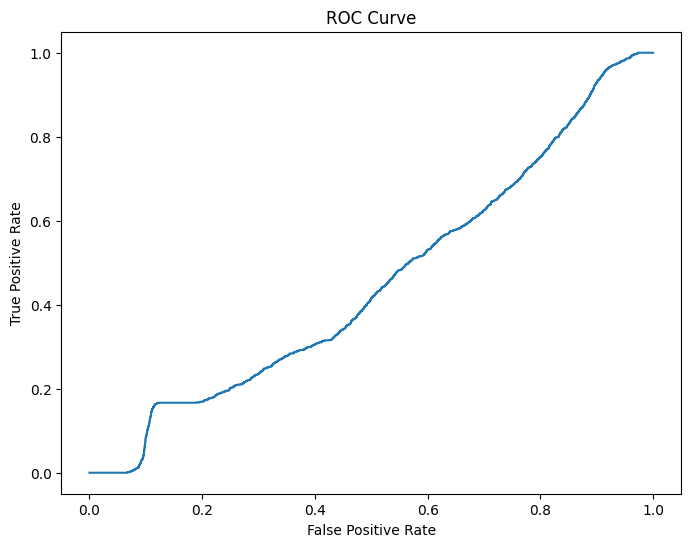

In [71]:
predictions = (outputs >= best_threshold).astype(int)
print("Performance on Validation Set:")
print(classification_report(trues, predictions , target_names=['Normal', 'Failure']))
print(confusion_matrix(trues, predictions ))
roc_auc = roc_auc_score(trues, outputs)
print(f"ROC AUC: {roc_auc:.4f}")
curve = roc_curve(trues, outputs)

plt.figure(figsize=(8, 6))
plt.plot(curve[0], curve[1], label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

Performance on Test Set:
🔍 Test Loss: 0.3335 | Accuracy: 84.39%
              precision    recall  f1-score   support

      Normal       0.99      0.85      0.92    263023
     Failure       0.02      0.35      0.03      1920

    accuracy                           0.84    264943
   macro avg       0.51      0.60      0.47    264943
weighted avg       0.99      0.84      0.91    264943

[[222896  40127]
 [  1239    681]]
ROC AUC: 0.6076


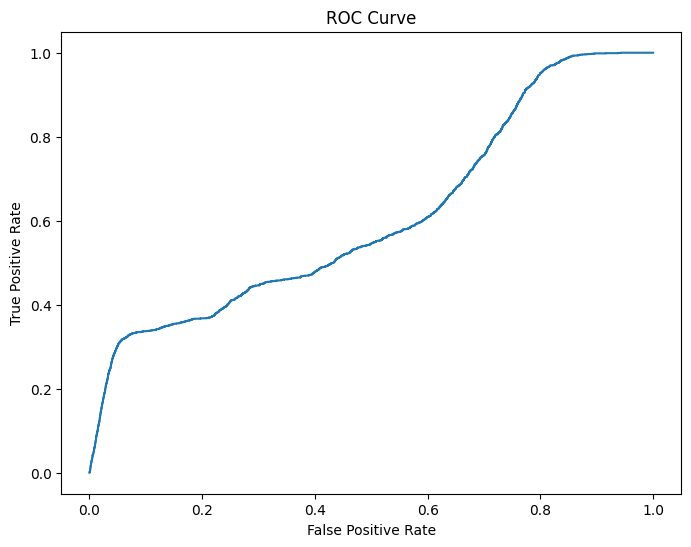

In [72]:
print("Performance on Test Set:")
evaluate_model(model, test_loader, best_threshold=best_threshold, device='cuda', criterion=criterion)